In [1]:
# Import required libraries
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

In [5]:
# Load the trained model
# Update the path to your trained model
model_path = '/home/ubuntu/esp-detection/runs/detect/train/weights/best.pt'
#model_path = '/home/ubuntu/esp-detection/runs/detect/train/weights/best.onnx'  # --- IGNORE ---
model = YOLO(model_path)

print(f"Model loaded from: {model_path}")
print(f"Model device: {model.device}")

Model loaded from: /home/ubuntu/esp-detection/runs/detect/train/weights/best.pt
Model device: cpu


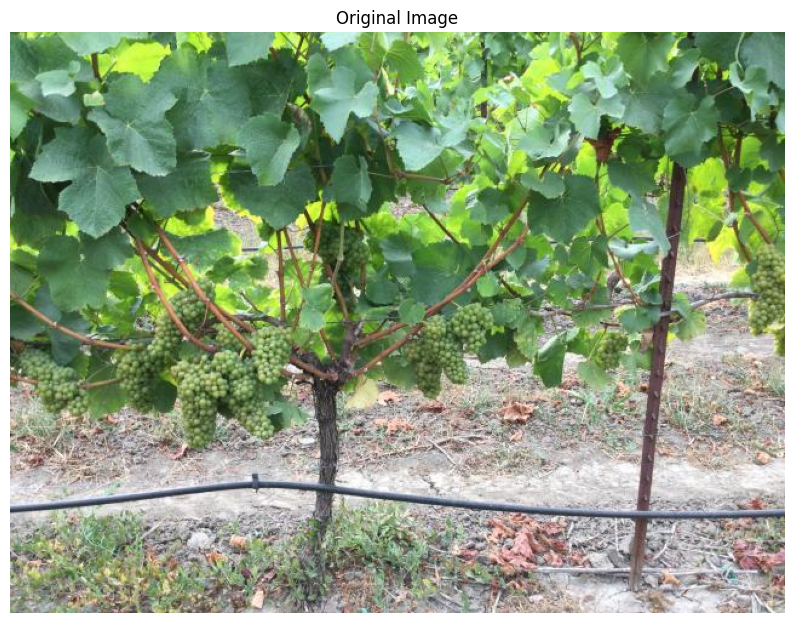

Image size: (640, 480)


In [7]:
# Load test image
test_image = 'espdet.jpg'  # or use any image from datasets/grape_leaf/test/images

# Display original image
img = Image.open(test_image)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

print(f"Image size: {img.size}")

In [8]:
# Run prediction
results = model(test_image, imgsz=224, conf=0.5)

# Get prediction details
result = results[0]
boxes = result.boxes

print(f"\nDetections: {len(boxes)}")
for i, box in enumerate(boxes):
    conf = box.conf.item()
    cls = int(box.cls.item())
    xyxy = box.xyxy[0].tolist()
    print(f"  Box {i+1}: class={cls} (leaf), confidence={conf:.3f}, bbox={xyxy}")


image 1/1 /home/ubuntu/esp-detection/espdet.jpg: 192x224 23 leafs, 117.6ms
Speed: 3.3ms preprocess, 117.6ms inference, 5.6ms postprocess per image at shape (1, 3, 192, 224)

Detections: 23
  Box 1: class=0 (leaf), confidence=0.804, bbox=[604.7605590820312, 0.0, 640.0, 45.329742431640625]
  Box 2: class=0 (leaf), confidence=0.801, bbox=[103.1307144165039, 96.63195037841797, 170.07327270507812, 151.55374145507812]
  Box 3: class=0 (leaf), confidence=0.785, bbox=[426.58966064453125, 117.5946273803711, 487.7177734375, 175.2541961669922]
  Box 4: class=0 (leaf), confidence=0.770, bbox=[105.52227020263672, 282.9228515625, 136.9163360595703, 314.9519348144531]
  Box 5: class=0 (leaf), confidence=0.765, bbox=[16.985767364501953, 75.22994995117188, 109.38519287109375, 171.6772918701172]
  Box 6: class=0 (leaf), confidence=0.753, bbox=[314.6239318847656, 70.47000885009766, 359.4937744140625, 115.42141723632812]
  Box 7: class=0 (leaf), confidence=0.733, bbox=[171.5574951171875, 0.0, 219.6450805

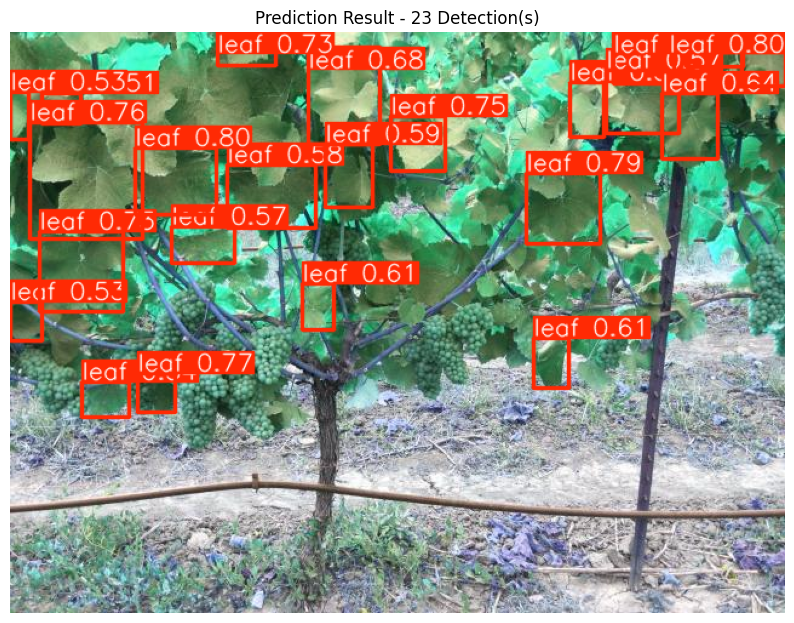

In [9]:
# Display prediction with bounding boxes
result_img = result.plot()

plt.figure(figsize=(10, 8))
plt.imshow(result_img)
plt.axis('off')
plt.title(f'Prediction Result - {len(boxes)} Detection(s)')
plt.show()


image 1/1 /home/ubuntu/esp-detection/datasets/grape_leaf/valid/images/SYH_2017-04-27_1260_jpg.rf.187c051ecca40b5bca6659cd6ca36295.jpg: 192x224 8 leafs, 12.7ms
Speed: 1.3ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 192, 224)

image 1/1 /home/ubuntu/esp-detection/datasets/grape_leaf/valid/images/SYH_2017-04-27_1294_jpg.rf.bac958400beda36b5c2cc890267d99d4.jpg: 192x224 8 leafs, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 224)

image 1/1 /home/ubuntu/esp-detection/datasets/grape_leaf/valid/images/CFR_1623_jpg.rf.da24fcfb0ec655eeed7d199e68d5794c.jpg: 192x224 17 leafs, 9.1ms
Speed: 0.9ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 224)

image 1/1 /home/ubuntu/esp-detection/datasets/grape_leaf/valid/images/IMG_1305_jpg.rf.532fc03916223b799b4ecf48ba0f980d.jpg: 192x224 22 leafs, 9.4ms
Speed: 1.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 2

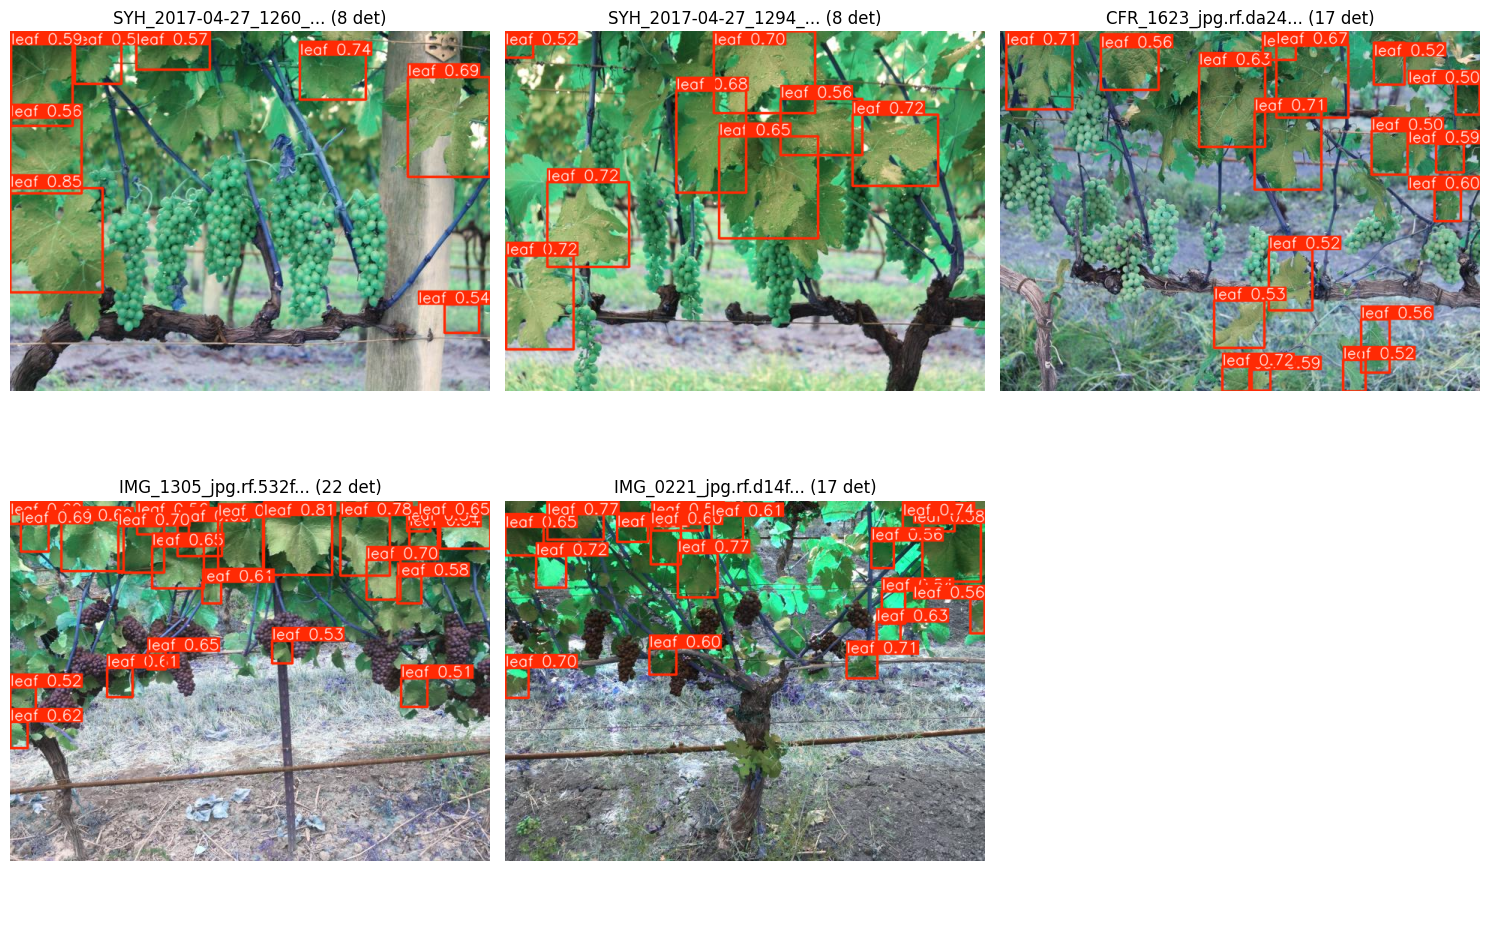

In [10]:
# Test on multiple images from validation set
val_images_dir = Path('datasets/grape_leaf/valid/images')
sample_images = list(val_images_dir.glob('*.jpg'))[:5]  # Get first 5 images

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    results = model(str(img_path), imgsz=224, conf=0.5)
    result_img = results[0].plot()
    
    axes[idx].imshow(result_img)
    axes[idx].axis('off')
    axes[idx].set_title(f'{img_path.name[:20]}... ({len(results[0].boxes)} det)')

# Hide unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save prediction result
save_path = 'prediction_result.jpg'
results = model(test_image, imgsz=224, conf=0.25)
results[0].save(save_path)

print(f"Prediction saved to: {save_path}")

## Testing Quantized Model (8-bit INT8)

The cells below test the **quantized model** that will be deployed to ESP32-S3.
This shows the actual prediction quality after 8-bit quantization.

In [ ]:
# Validate quantized model on validation dataset
# This measures accuracy of the 8-bit quantized model

import sys
sys.path.append('deploy')

from deploy.eval_quantized_model import ppq_graph_init, make_quant_validator_class, quant
import os

# Check if quantized model exists
native_path = "deploy/espdet_pico_224_224_grape_leaf.native"
espdl_path = "deploy/espdet_pico_224_224_grape_leaf.espdl"

if os.path.exists(native_path):
    print(f"✓ Found quantized model: {native_path}")
else:
    print(f"⚠️  Quantized model not found. Run 'sh espdet_run.sh' first.")
    print(f"   Looking for: {native_path}")

if os.path.exists(espdl_path):
    print(f"✓ Found ESP-DL model: {espdl_path}")
    # Get file size
    size_kb = os.path.getsize(espdl_path) / 1024
    print(f"   Size: {size_kb:.2f} KB")
else:
    print(f"⚠️  ESP-DL model not found.")
    print(f"   Looking for: {espdl_path}")

In [ ]:
# Run validation to get mAP metrics of quantized model
# This compares quantized vs original model accuracy

if os.path.exists(native_path):
    print("Loading quantized model executor...")
    executor = ppq_graph_init(
        quant_func=quant,
        imgsz=224,
        device="cpu",
        native_path=native_path
    )
    
    # Load original model
    model_fp32 = YOLO("runs/detect/train/weights/best.pt")
    
    # Create quantized validator
    QuantDetectionValidator = make_quant_validator_class(executor)
    
    print("\nRunning validation on quantized model (this may take a few minutes)...")
    results_quant = model_fp32.val(
        data="datasets/grape_leaf/data.yaml",
        split="val",
        imgsz=224,
        device="cpu",
        validator=QuantDetectionValidator,
        save_json=False,
        save=False,
    )
    
    print("\n" + "="*60)
    print("QUANTIZED MODEL METRICS (8-bit INT8):")
    print("="*60)
    print(f"mAP50-95: {results_quant.box.map:.4f}")
    print(f"mAP50:    {results_quant.box.map50:.4f}")
    print(f"mAP75:    {results_quant.box.map75:.4f}")
    print(f"Precision: {results_quant.box.mp:.4f}")
    print(f"Recall:    {results_quant.box.mr:.4f}")
    print("="*60)
    
    print("\nNote: Compare with FP32 model metrics to see quantization impact")
    print("      Typical accuracy loss: 1-5% mAP")
else:
    print("Quantized model not available. Run quantization first.")